### Model Evaluation and Improvement


`train_test_split` example:

In [17]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
    # create a synthetic dataset
X, y = make_blobs(random_state=0)
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 
# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)
# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))


Test set score: 0.88


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Cross-Validation

Data is split repeteadly and multiple models are trained. Most common is *k-fold cv* where $k$ is number of folds (usually 5 or 10). Each fold is the test set once.

- Chossing 5 folds, 4 folds will be training, one fold will be test data.
- Repeated 5 times (there are 5 splits of data in this manner)

For each of these splits we compute accuracy, we collect 5 accuracy scores in the end. 

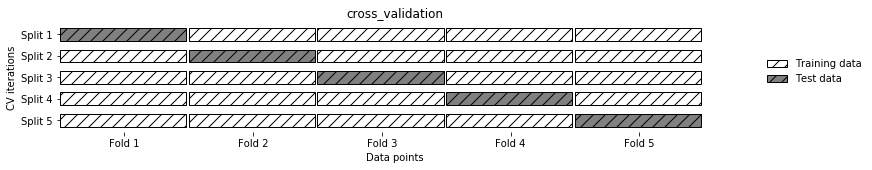

In [6]:
import mglearn as mglearn
import matplotlib.pyplot as plt
mglearn.plots.plot_cross_validation()

CV implemented in scikit-learn using `cross_val_score(model, training, target)`

In [23]:
from sklearn.model_selection import cross_val_score 
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
scores = cross_val_score(logreg, iris.data, iris.target, cv=3) 
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.98039216 0.94117647 1.        ]


In [15]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print(scores)


[0.96666667 1.         0.93333333 0.96666667 1.        ]


In [18]:
np.mean(scores)

0.9733333333333334

We will expect our model to be 96% accurate on average. Relatively high variance between folds.

- Could imply that model is dependent on the particular folds used for training

`cross_val_score` does not return a model, the purpose is to evaluate how well a given algorithm will generalize when trained on a specif dataset.

### Stratified k-Fold Cross Validation

Splitting the data into $k$-folds might not always be a good idea.

In [19]:
from sklearn.datasets import load_iris
iris = load_iris()

print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Splitting the data in 3 folds like this will get us a fold with only class 0, second fold with only class 1.

**In stratified k-fold CV, data is split in such a way that the proportions between classes are the same in each fold as they are in the whole dataset**

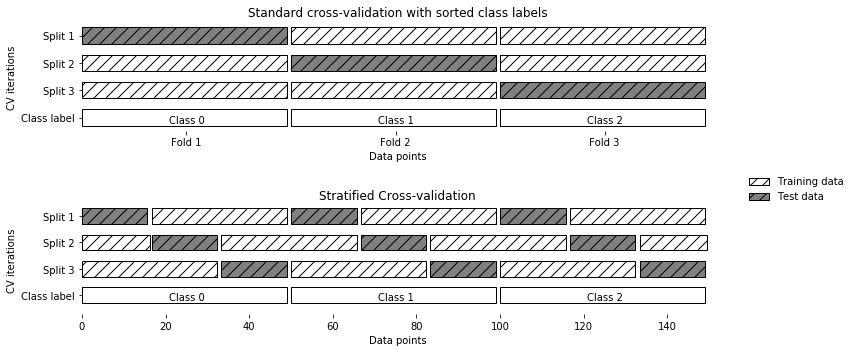

In [20]:
mglearn.plots.plot_stratified_cross_validation()

Usually a good idea to use stratified k-fold CV to evaluate a classifier. 

- For most cases k-fold CV for regression and stratified k-fold CV for classification works well. But there is a lot more one can do.

For example, if we want to use k-fold CV to make reproducible results. We need to import `KFold` splittler class.

In [24]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

cross_val_score(logreg, iris.data, iris.target, cv=kfold)

array([1.        , 1.        , 0.86666667, 0.93333333, 0.83333333])

As mentioned earlier, it is really bad idea to three-fold (non-stratified CV) on the iris dataset.

In [25]:
kfold = KFold(n_splits=3)

cross_val_score(logreg, iris.data, iris.target, cv=kfold)

array([0., 0., 0.])

A way to solve this problem, is to **shuffle the data**

In [26]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print(cross_val_score(logreg, iris.data,
                      iris.target, cv=kfold))

[0.98 0.96 0.96]


### Leave-one-out CV

Think of it as k-fold CV where each fold is **a single sample**. For each split you pick a single poitn to be test set.

In [27]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target,
                        cv=loo)

In [29]:
print(len(scores))
print(np.mean(scores))

150
0.9666666666666667


### Shuffle-split cross-validation

Each split samples *train_size* many points for the training set and *test_size* (disjoint) points for the test set.

- Repeated n-iter times.


Illustration: 10 points, 5 points in training, 2 test sets of 2 points each.

-**It allows to use only a part of the data in each iteration, by providing train_size and test_size settings that don't add up to one**

- Subsampling the data in this way can be **VERY USEFUL for large datasets**

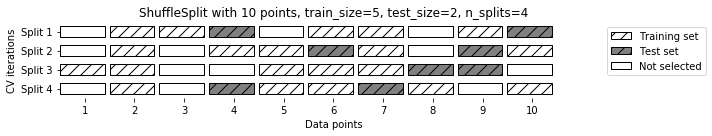

In [30]:
mglearn.plots.plot_shuffle_split()

For classification tasks, might be better to use `StratifiedShuffleSplit`

### Cross Validation with groups

Say you want to build a classifier that recognizes emotions from pictures of faces. You collect 100 people where each person is captured multiple times, showing various emotions.

- Goal is to build a classifier that can **identify emotions of people not in the dataset.**

To accurately evaluate generalization of the model to new faces, **we must enseure that the training and test sets contain images of differnet people**


We can use `GroupKFold` which takes an array of **groups** as argument that we can use to indicate which person is in the image. The **groups** here indicate groups in the data that **should not be split when creating training a test sets** (don't confuse it with the class labels).

- In this example, data consists of 12 points, for each of the data points, groups specifies which group (think of patient) the points belongs to. The groups specify that there are four groups.

**Each group is either entirely on the training set or entirely in the test set**

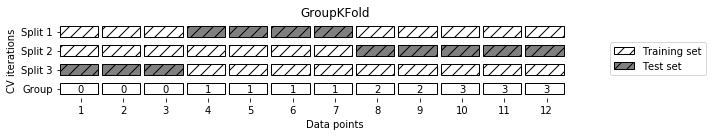

In [39]:
mglearn.plots.plot_group_kfold()

In [40]:
from sklearn.model_selection import GroupKFold
# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group, # then the next four, etc. 

print('Emotions: ', y)
groups=[0,0,0,1,1,1,1,2,2,3,3,3]
print('Persons: ', groups)

scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3)) 
print("Cross-validation scores:\n{}".format(scores))


Emotions:  [1 0 2 0 0 1 1 2 0 2 2 1]
Persons:  [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
Cross-validation scores:
[0.75       0.6        0.66666667]


`KFold`, `StratifiedKFold` and `GroupKFold` are the most common splitting strategies.

### Grid Search


Trying all possible combinations of the parameters of interest. 

**Using the test data to adjust the paramters, we can no longer use it to asses how good the model is** We need an independet dataset to evaluate, one that was not used for it

In [42]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC

X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data,
                                                          iris.target,
                                                          random_state=0)
# split train+ validation set into training and validation sets

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval,
                                                     random_state=1)

print('Size of training set: {} size of validation set {} size of test set: {}'.format(X_train.shape[0],
                                                                                       X_valid.shape[0],
                                                                                       X_test.shape[0]))

best_score =0 

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination train SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        
        # if we get a better score, store score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 
                               'gamma':gamma}
            
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print('Best score on validation {}'.format(best_score))
print('Best parameters ', best_parameters)
print('Test set score with best parameters {:.2f}'.format(test_score))


Size of training set: 84 size of validation set 28 size of test set: 38
Best score on validation 0.9642857142857143
Best parameters  {'C': 10, 'gamma': 0.001}
Test set score with best parameters 0.92


The best score on validation was 96%, however the score on the test set (how we generalize) is 92%, so **we can only claim to classify new data 92% correctly**.

### Grid Search CV

While this method of splitting data into training, validation and test set is commonly used: it is sensitive to how data is split.

In [47]:
best_score = 0
# for each combination of parameters trains an SVC
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        # perform CV
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean CV accuracy
        score = np.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild model on combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

print(svm.score(X_test, y_test))

0.9736842105263158


To avoid it, use `GridSearchCV`:
- Define a dictionary where the keys are the names of the parameters we want to adjust.

**The important thing is to not use the test set to choose the parameters**

In [51]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# parameters to test
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.001, 0.1, 1, 10,100]}

grid_search = GridSearchCV(SVC(), 
                           param_grid, cv=5)

# GridSearchCV will use CV in place of the split into a training
# and validatio set that we used 

X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    random_state=0)
# we have single split!!!!
grid_search.fit(X_train, y_train)
# automatically fits model on the whole training data,
# using the parameters with the best scores!

print("Test Set Score {}".format(grid_search.score(X_test, y_test)))

Test Set Score 0.9736842105263158


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [52]:
# returns the best model
grid_search.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
import pandas as pd
from IPython.display import display

results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001026,0.000230,0.000548,0.000175,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,21,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000832,0.000145,0.000380,0.000050,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,21,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000891,0.000106,0.000471,0.000091,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,21,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.001032,0.000314,0.000554,0.000274,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,21,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.001096,0.000231,0.000496,0.000069,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,21,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


In [57]:
# 36 different models
results.shape

(36, 22)

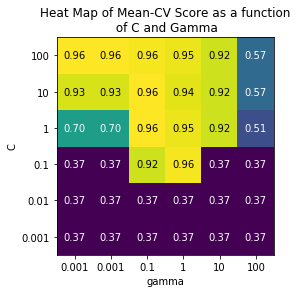

In [64]:
scores = np.array(results['mean_test_score']).reshape(-6,6)
mglearn.tools.heatmap(scores, xlabel='gamma', 
                      xticklabels=param_grid['gamma'],
                    ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

plt.title('Heat Map of Mean-CV Score as a function\n of C and Gamma')
plt.show()

Light colors meanning high accuracy, dark colors low accuracy. You see that SVM is very sensitive. For many parameters is 37% accurate and adjusting parameters changes it to 96%. 

**The ranges we picked are significant in the outcome, if serach ranges are not chosen properly**



#### Seach over spaces that are not grids

In [67]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]},
             {'kernel': ['linear'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


grid_search = GridSearchCV(SVC(), 
                           param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameters ', grid_search.best_params_)
print('Best CV score {:.2f}'.format(grid_search.best_score_))

Best parameters  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV score 0.97


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [68]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00149035,0.00142097,0.00101271,0.000975752,0.00108175,0.0010644,0.000873756,0.000936031,0.000719929,0.000818014,...,0.000600195,0.000857162,0.00130067,0.00174346,0.000901175,0.000696611,0.00116086,0.00143261,0.00108719,0.000703144
std_fit_time,0.000222554,0.000248596,0.00025267,0.000121641,0.000220673,0.000228125,0.000216052,0.000298726,6.74743e-05,0.000146635,...,0.000243764,0.000364975,0.00037339,0.0010178,0.000295129,0.000228764,0.00116976,0.00133329,0.000474102,0.000378339
mean_score_time,0.000790167,0.000728416,0.000508261,0.000434399,0.000553036,0.000625706,0.000488234,0.000502539,0.0003263,0.000452185,...,0.000411654,0.000378513,0.000552034,0.000428295,0.000749445,0.000456715,0.000437593,0.000528193,0.000458813,0.000344563
std_score_time,0.000110629,0.000159128,0.00016923,3.52495e-05,0.000150389,0.000253541,0.000114958,0.000148336,1.7349e-05,0.000127931,...,0.000142134,0.000107174,0.00024637,9.73319e-05,0.000635993,0.000238863,0.000224465,0.000145618,0.000161879,0.00013495
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.521739,0.347826,0.826087,0.913043,0.956522,1,1


`GridSearchCV` uses stratified k-fold CV by default for classification and k-fold CV for regression. However, you can also pass any CV splitter.

- To get a single split into a trining and validation set, you can use `ShuffleSplit` or `StratifiedShuffleSplit` with `n_iter=1`. **Helpful for very large datasets**

#### Nested cross-validation

As described earlier, for `GridSearchCV` we must split our data into train and test sets. **This might make our results to depend too much on the single split of the data**

- We can use multiple splits! This results in **nested cross validation**.

- The result of this procedure is a list of scores - not a model or parameter setting.

- Nested CV is rarely used when looking for a predictive model to apply. But it is useful to evaluate how well a given model works for a particular data sets.

In [69]:
# 3 for loops
# outer for loop: splits into train an test
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)

print('Cross validation scores {}'.format(scores))

Cross validation scores [0.96666667 1.         0.9        0.96666667 1.        ]


In [70]:
print(scores.mean())

0.9666666666666668


We used 5-fold CV in both inner and outer loop. As our param_grid contains 36 possible combinations. We have $36*5*5=900$

### Evaluation Metrics and Scoring

#### Metrics for Binary Classification

In statistics, false positives known as Type I error. False negatives known as Type II errors. **In a cancer diagnosis example, we want to avoid false negative as much as possible, while false positives can be viewed as a minor problem**

- The consequences of false positives and false negatives are rarely the same. 

#### Imbalanced datasets

To illustrate this, create a 9:1 imbalanced data.

In [71]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

We use `DummyClassifier` to always predict the majority class:

In [73]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

print('Predicted only false ', np.unique(pred_most_frequent))

Predicted only false  [False]


In [74]:
dummy_majority.score(X_test, y_test)

0.8955555555555555

We obtained 90% accuracy without learning anything. Let's make another model with `DecisionTreeClassifier`.

In [75]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)

print(tree.score(X_test, y_test))

0.9177777777777778


According to accuracy, this model is only slightly better. Let's make another one.

In [77]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)

print('LogisticRegression Score {}'.format(logreg.score(X_test, y_test)))

LogisticRegression Score 0.9777777777777777


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Accuracy is not the right way to evaluate model on the data like this** 

#### Confusion Matrices

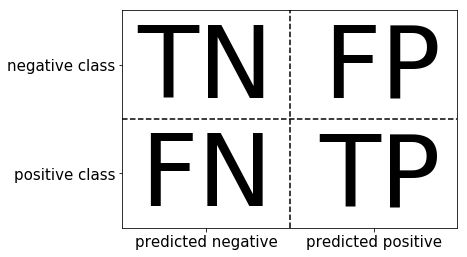

In [80]:
mglearn.plots.plot_binary_confusion_matrix()

In [78]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)

[[401   2]
 [  8  39]]


In [82]:
print('Most Frequent Class')
print(confusion_matrix(y_test, pred_most_frequent))
print('Decision Tree')
print(confusion_matrix(y_test, pred_tree))
print('Logistic Regression')
print(confusion_matrix(y_test, pred_logreg))

Most Frequent Class
[[403   0]
 [ 47   0]]
Decision Tree
[[390  13]
 [ 24  23]]
Logistic Regression
[[401   2]
 [  8  39]]


$Accuracy = \dfrac{TP+TN}{TP+TN+FP+FN}$

#### Precision, recall, f-score

There are several ways to summarize confusion matrices. Most common ones being precision and recall.

- **Precision** measures how many samples predicted as positive are actually positive. Used to **avoid false positives** z.B wether a new drug will be effective in treating diseases. 

    $Precision = \dfrac{TP}{TP+FP}$

- **Recall** measures how many positive samples are captured by the positive predictions. Used when we need to identify all positve samples, **when it is important to avoid false negatives**.

    $Recall = \dfrac{TP}{TP+FN}$

There is a trade-off between optimizing recall and optimizing precision. You can obtain perfect recall if you predict all samples to belong to the positive class (no FN, no TN either). This will result in many FP, so precision will be very low. 


- One way to summarize precision and recall: is the f-score
    
    $F_1 = 2 * \dfrac{precision*recall}{precision+recall}$

In [84]:
from sklearn.metrics import f1_score
print('f1 score most frequent {:.2f}'.format(f1_score(y_test, pred_most_frequent)))
print('f1 score tree {:.2f}'.format(f1_score(y_test, pred_tree)))
print('f1 score logreg {:.2f}'.format(f1_score(y_test, pred_logreg)))

f1 score most frequent 0.00
f1 score tree 0.55
f1 score logreg 0.89


/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


- We can see a strong distinction between the dummy and the tree predictions (this wasn't clear) looking at only accuracy.

For a more comprehensive precision, recall and $f_1$-score we can use `classification_report`.

In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent,target_names=['not nine', 'nine']))


              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

   micro avg       0.90      0.90      0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The `classification_report` produces one line per class.

In [95]:
print(classification_report(y_test, pred_tree, target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.94      0.97      0.95       403
        nine       0.64      0.49      0.55        47

   micro avg       0.92      0.92      0.92       450
   macro avg       0.79      0.73      0.75       450
weighted avg       0.91      0.92      0.91       450



In [96]:
print(classification_report(y_test, pred_logreg, target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



While the f-score for the dummy classification is 0.13 (vs. 0.89 for the logistic regression) on the “nine” class, for the “not nine” class it is 0.90 vs. 0.99, which both seem like reasonable results. **Looking at all the numbers together paints a pretty accurate picture, though, and we can clearly see the superiority of the logistic regression model.**

### Uncertainty

- Most classifiers privde a `decision_function` or a `predict_proba` to assess the degree of **certainty about predictions**.

- Making predictions **can be seen as tresholding the output of the decision function or predict_proba at a certain fixed point -in binary classification we use 0 for the decision function and 0.5 for predict_proba**

In [98]:
from mglearn.datasets import make_blobs
X, y = make_blobs(n_samples=(400,50), centers=2,
                    cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


- We have 400 samples from one class, 50 from another.

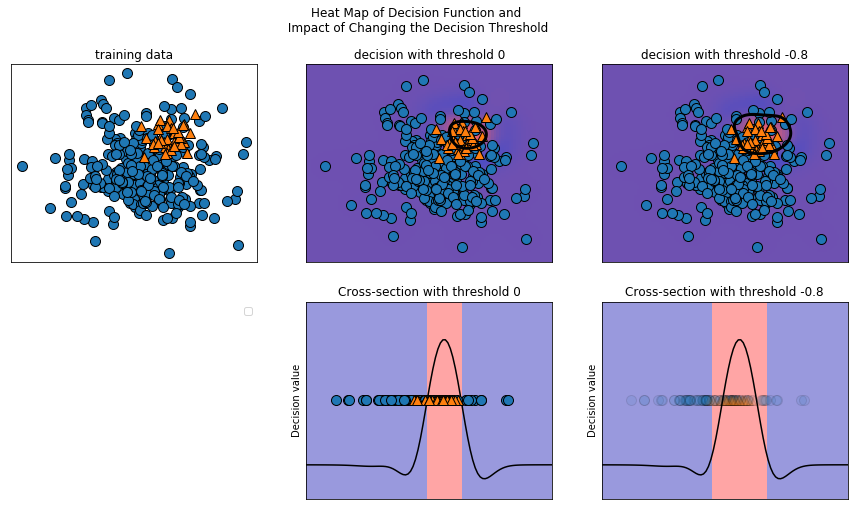

In [103]:
mglearn.plots.plot_decision_threshold()
plt.suptitle('Heat Map of Decision Function and\n Impact of Changing the Decision Threshold')
plt.show()

In [106]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

   micro avg       0.88      0.88      0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



**Because class 0 is much larger (400 samples) the classifier focuses on getting class 0 right and not the smaller class 1**


- Let us assume that having a high recall for class 1 is more important. We need to adjust the predictions to focus on a higher recall of class 1, **by changing the decision threshold away from 0**. 


- Points with a decision_function value > 0 will be classified as class 1. We need to decrease the threshold to get more classiffied as 1.

In [109]:
# DAMNNN
y_pred_lower_threshold = svc.decision_function(X_test) > -0.8

In [110]:
print(classification_report(y_test, 
                            y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

   micro avg       0.83      0.83      0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



As decision function can have arbitrary ranges, it is hard to have a rule of thumb to pick the threshold.

For models that implement `predict_proba` method changing the threshold can be easier. By default a threshold >0.5 means that if the model is more than 50% sure that a point is of the positive class, it will be classified as such.

**Not all models provide realistic models of uncertainty ( a `DecisionTree` that is grown full depth is always 100% sure of predictions, even if they are wrong)**. 

- Calibaration: a calibrated model provides an accurate version of uncertainty.

### Precision-Recall Curves and ROC curves

**It is always possible to set a threshold to fulfill a particular target**, like 90% recall. The hard part is to develop a model that still has reasonable precision with this threshold - classify everything as positive, you will have 100% recall.

It is not always clear what setting to use. To understand a modelling problem better, it is useful to **look at all positive thresholds** all possible trade-offs of precision and recalls at once.

In [111]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       svc.decision_function(X_test))

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


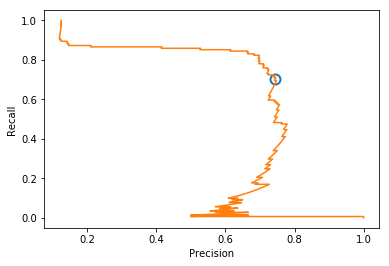

In [141]:
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=40)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
svc = SVC(gamma=0.5).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o',
         markersize=10, label='threshold zero', fillstyle='none', mew=2)

plt.plot(precision, recall, label='precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()



In [142]:
len(precision)

1124

In [148]:
precision[-1]

1.0

In [143]:
len(recall)

1124

In [150]:
recall[-1]

0.0

In [145]:
len(thresholds)

1123

In [152]:
thresholds[-1]

1.2572932989366008

Each point along the curve is a possible threshold of the `decision_function`. The blue circle corresponds to the threshold of 0, **the default**.

- The closer the curve stays to the upper-right, the better the classifer (high precision and high threshold).

- Let's see another classifier a `RandomForestClassifier` (only has `predict_proba` method). **The `precision_recall_curve` expects as its second argument a certainty measure for class (1) so we pass the probability of a sample being class 1.**

In [117]:
rf.predict_proba(X_test)[:,1] + rf.predict_proba(X_test)[:,0]

array([1., 1., 1., ..., 1., 1., 1.])

In [147]:
?precision_recall_curve()

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


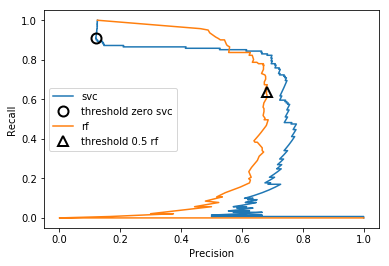

In [215]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=40)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
svc = SVC(gamma=0.5).fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)
# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])



plt.plot(precision, recall, label="svc")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)
plt.plot(precision_rf, recall_rf, label="rf")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

In [158]:
len(precision_rf)

91

In [159]:
len(recall_rf)

91

In [160]:
len(thresholds_rf)

90

We can see that the random forest ist better at the extremes. (for very high recall or high precision requirements). 

- If we only have looked at the $f_1$ score we would have missed this.

In [131]:
print("f1 score of random_forest {:.2f}".format(f1_score(y_test, rf.predict(X_test))))

f1 score of random_forest 0.65


In [132]:
print('f1_score of svc {:.2f}'.format(f1_score(y_test,
                                               svc.predict(X_test))))

f1_score of svc 0.72


Comparing two precision-recall curves provides detailed info, but is manual.

- For automatic comparison, we might want to summarize the info in the curves.

- One particuarl way to summarize precision-recall curve is by computing the integral or area under the curve known as **average precision**. Returns a value between **0(worst) and 1(best)**.


In [133]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, 
                                 svc.decision_function(X_test))
print('Average precision of RF ', ap_rf)
print('Average precision of SVC ', ap_svc)

Average precision of RF  0.5970845256758521
Average precision of SVC  0.6375886548347448


### Receiver Operating Characteristics ROC and AUC

Another tool used to analyze the behavior of classifiers at different thresholds: ROC (it also considers all possible thresholds but instead of reporting precision and recall it shows:

- False Positive Rate $= \dfrac{FP}{FP+TN}$


- True Positive Rate, Recall $= \dfrac{TP}{TP + FN}$

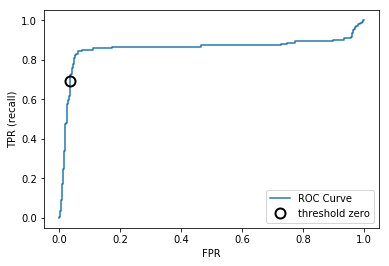

In [162]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, 
                                 svc.decision_function(X_test))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR (recall)')

close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', 
         markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.show()

- Ideal curve is close to the top left: you want a classifier that produces **high recall and low false positive rate**.


- **Here it is not right to choose thresholds with the test sets! We should do it with a validation set!**

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


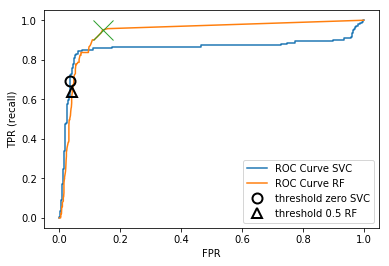

In [216]:
from sklearn.metrics import roc_curve

X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=40)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)


plt.plot(fpr_rf[best_index], tpr_rf[best_index], 'x', markersize=20)


plt.legend(loc=4)
plt.show()

In [269]:
rf.predict_proba(X_test)[:,0] + rf.predict_proba(X_test)[:,1]

array([1., 1., 1., ..., 1., 1., 1.])

- Notice what `roc_curve` returns:

In [167]:
len(fpr_rf)

87

In [168]:
len(tpr_rf)

87

In [170]:
len(thresholds_rf)

87

### They left this important thing out?

**=> we pick the threshold that suits are need. And feed into our predict_proba bzw. decision_function to adjust our predictions!**

In [220]:
np.sum(y_test == np.unique(y)[0])

984

In [221]:
np.sum(y_test == np.unique(y)[1])

141

In [268]:
?roc_curve()

In [219]:
rf.predict_proba(X_test)

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.56, 0.44],
       [0.84, 0.16]])

In [174]:
optimal_idx = np.argmax(np.abs(tpr_rf - fpr_rf))
optimal_threshold = thresholds_rf[optimal_idx]

In [176]:
optimal_threshold

0.02

Using the treshold of 0.02, from a total number of 1125 samples, we predicted 267 to 'have cancer'. In total they are 141 patients with cancer.

In [261]:
sum(rf.predict_proba(X_test)[:,1]>0.02)

267

In [ ]:
141

In [185]:
best_index = np.where(thresholds_rf == optimal_threshold)

In [238]:
y_pred_best_threshold = rf.predict_proba(X_test)[:,1] > optimal_threshold


In [203]:
y_pred_best_threshold

array([False, False, False, ..., False, False, False])

In [239]:
print(classification_report(y_test, 
                            y_pred_best_threshold))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       984
           1       0.49      0.94      0.65       141

   micro avg       0.87      0.87      0.87      1125
   macro avg       0.74      0.90      0.78      1125
weighted avg       0.93      0.87      0.89      1125



In [241]:
500/4000

0.125

In [235]:
from sklearn.metrics import recall_score
# gets rounded up!! ABILITY TO FIND ALL THE POSITIVE SAMPLES!!!!
# WE WANT TO AVOID FALSE NEGATIVE!
recall_score(y_test, y_pred_best_threshold)

0.9361702127659575

- False positives don't matter too much! All we want is to maximize recall for the imbalanced class!

In [229]:
?recall_score

_ _ _ _ _ _ _ __ _
_ _ _ _

We can also summarize the ROC with a single number, the area under the curve of the ROC, the AUC.

- Predicting randomly always produces an AUC score of 0.5, no matter how imbalanced the classes are. This makes **AUC much better for imbalanced classification than accuracy**

In [138]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print('AUC for RF ', rf_auc)
print('AUC for SVC ', svc_auc)

AUC for RF  0.9349953871879144
AUC for SVC  0.8563541486478695


- **AUC can be interpreted as evaluating the ranking of positive samples.**
- Here RF performs better than AUC.

gamma = 1.00 accuracy = 0.90 AUC = 0.50
gamma = 0.05 accuracy = 0.90 AUC = 1.00
gamma = 0.01 accuracy = 0.90 AUC = 1.00


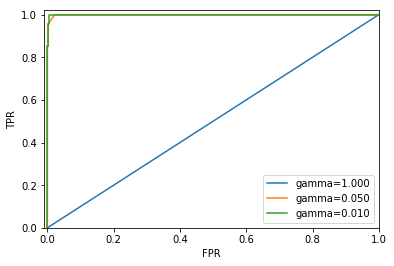

In [140]:
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(
        digits.data, y, random_state=0)
plt.figure()
for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test)) 
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test)) 
    print("gamma = {:.2f} accuracy = {:.2f} AUC = {:.2f}".format( gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

- AUC does not make use of the default threshold, adjusting the decision threshold might be necessary to obtain useful classification results from a model with a high AUC.

### Metrics for Multiclass Classification

Let's classify 10 different handwritten digits.

In [274]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target,
                                                    random_state=0)
lr = LogisticRegression(multi_class='auto').fit(X_train, y_train)
pred = lr.predict(X_test)

print('Accuracy', accuracy_score(y_test, pred))
print('Confusion Matrix\n{}'.format(confusion_matrix(y_test,
                                                     pred)))


Accuracy 0.9533333333333334
Confusion Matrix
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- The model has 95.3 % accuracy.
- The confusion matrix shows it's doing pretty well.

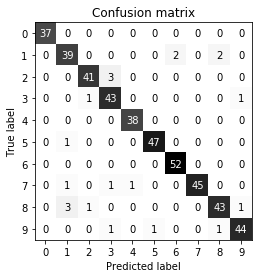

In [275]:
scores_image = mglearn.tools.heatmap(
      confusion_matrix(y_test, pred), xlabel='Predicted label',
      ylabel='True label', xticklabels=digits.target_names,
      yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()


For class 0, there are 37 samples and all were classified as 0. (**No false negatives for this class**). Also all other entries in the first row show that no other digits were classified as 0: **there no false positives for this class**.

In [277]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



- For class 6 (row) there are no false positives: recall is 1.
- For class 7 there were no false negatives, precision is 1.
- For class 0 no false positives or false negatives, recall and precision are 1.

**The most commonly used metric for imbalanced datasets in the multiclass setting is the multiclass version of the f-score**

- Compute one binary f-score per class, **with that class being positive and the other classes as negative**.
- These class f-scores are averaged using these strategies:
    - `macro` : equal weight to all classes (average)
    - `weighted`: average of scores, **weighted by their support**. What is shown in the classification report.
    - `micro`: computes total number of FP, FN and TP over all classes, and then computes (precision, recall) and f-scores using these counts.
    
If you care a lot about each sample: use `micro`. 
If yoou care about each class equally much use `macro`. 


In [280]:
print('Micro average f1 score {:.4f}'.format(f1_score(y_test,
                                                      pred,
                                                      average='micro')))
print('Macro average f1 score {:.4f}'.format(f1_score(y_test,
                                                      pred,
                                                      average='macro')))

Micro average f1 score 0.9533
Macro average f1 score 0.9540


### Using Evaluation Metrics in Model Selection

Often we wan to use metrics like `AUC` using `GridSearchCV` or `cross_val_score`. 

- You can achieve this using the `scoring` argument of `GridSearchCV` and `cross_val_score`. 

To change `roc_auc` instead of the standard accuracy:

In [293]:
    # default scoring for classification is accuracy
print("Default scoring: {}".format(
cross_val_score(SVC(gamma='scale'), digits.data, digits.target == 9, cv=3)))
    # providing scoring="accuracy" doesn't change the results
explicit_accuracy =  cross_val_score(SVC(gamma='scale'), digits.data, digits.target == 9,
                                         scoring="accuracy", cv=3)
print("Explicit accuracy scoring: {}".format(explicit_accuracy)) 
roc_auc = cross_val_score(SVC(gamma='auto'), digits.data, digits.target == 9,
scoring="roc_auc", cv=3) 
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.97328881 0.96494157 0.97996661]
Explicit accuracy scoring: [0.97328881 0.96494157 0.97996661]
AUC scoring: [0.99372294 0.98957947 0.99594929]


Default was accuracy_score. First and second line do not vary.

- We can change the metric used **pick the best parameters in `GridSearchCV`.

In [299]:
X_train, X_test, y_train, y_test = train_test_split(
        digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]} 
# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3) 
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test)))) 
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973


Choosing the parameters with **AUC** as metric, provides different results. 

In [301]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc", cv=3) 
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_)) 
print("Test set AUC: {:.3f}".format(
roc_auc_score(y_test, grid.decision_function(X_test)))) 
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))



Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


Here we performed better with `AUC` because accuracy isn't a good metric in imbalanced datasets.

The most important `scoring` parameters for classification:
- `roc_auc` for ROC 
- `average_precision` for precision-recall curve
- `f1` (macro, micro, weighted) for the binary and variantes.
For regression:
- `r2` for $R^2$
- `mean_squared_error` 
- `mean_absolute_error`.

In [302]:
from sklearn.metrics.scorer import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])
